## Install package and get dataset

install package kaggle untuk memanggil dataset di platform tersebut

In [1]:
!pip install -q kaggle

upload kredensial akun kaggle untuk autentikasi

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"paullestyo","key":"4478a528483cd98297247fa2aa60b9c8"}'}

memindahkan file kredensial agar dapat dikenali

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mengunduh dataset kaggle [muhammadghazimuharam/indonesiafalsenews](https://www.kaggle.com/datasets/muhammadghazimuharam/indonesiafalsenews) yang berupa dataset fake news menggunakan bahasa Indonesia

In [4]:
! kaggle datasets download -d muhammadghazimuharam/indonesiafalsenews
! mkdir data
! unzip indonesiafalsenews -d data

  0% 0.00/548k [00:00<?, ?B/s]
100% 548k/548k [00:00<00:00, 112MB/s]
Archive:  indonesiafalsenews.zip
  inflating: data/Data_latih.csv     
  inflating: data/Data_uji.csv       


melakukan import library yang dibutuhkan untuk pemrosesan, training, maupun visualisasi data

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
import nltk

from wordcloud import WordCloud
from sklearn.metrics import f1_score

%matplotlib inline

# Data Understanding

membaca dataset yang berbentuk csv dan menampilkan beberapa data

In [6]:
news= pd.read_csv('data/Data_latih.csv')
news.head()

,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,17-Aug-20,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,17-Jul-20,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,13-Jul-20,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,8-Jul-20,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,24-Jun-20,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg


melihat banyak data berdasarkan label benar/salah berita tersebut fake news

In [12]:
news['label'].value_counts()

1    3465
0     766
Name: label, dtype: int64

menampilkan distribusi data berdasar label menggunakan bar chart. Terlihat bahwa data dengan label fake news (label 1) lebih banyak dibandingkan yang tidak.

<Axes: xlabel='label'>

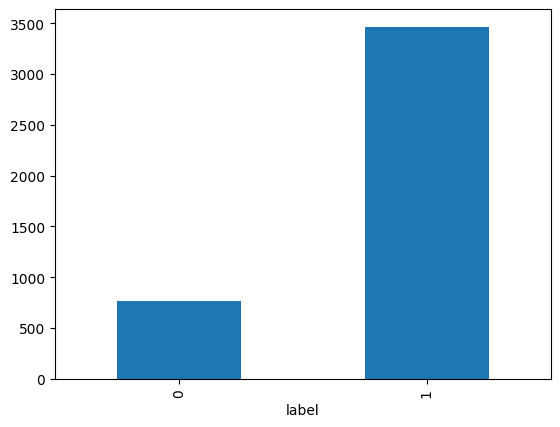

In [13]:
news.groupby('label').size().plot(kind='bar')

preview salah satu judul dataset

In [14]:
news.iloc[1].judul

'Instruksi Gubernur Jateng tentang penilangan  bagi yg tidak bermasker di muka umum Rp.150.000 menggunakan e-tilang Via apps PIKOBAR'

menampilkan panjang karakter dari salah satu judul

In [16]:
len(news.iloc[1].judul)

131

menampilkan visual grafik terkait panjang karakter semua dataset. Dapat diketahui bahwa distribusi panjang karakter cenderung right skewness

<Axes: >

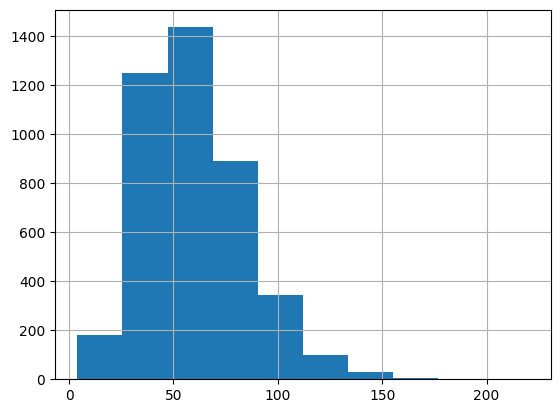

In [17]:
news['judul'].str.len().hist()

menampilkan grafik visual banyaknya kata pada tiap judul untuk seluruh dataset

<Axes: >

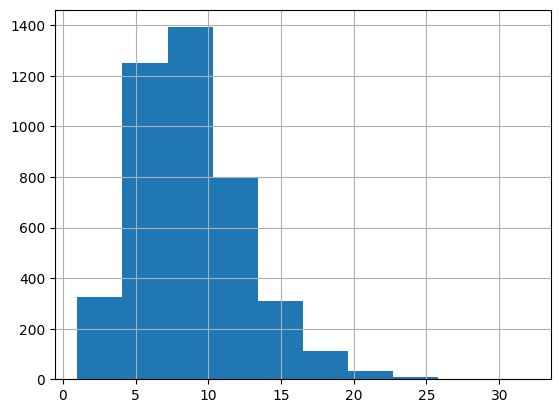

In [18]:
news['judul'].str.split().map(lambda x: len(x)).hist()

# Data Preparation for ML Model

mempersiapkan stopword untuk membersihkan kata pada judul saat dibuat grafik

In [19]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('indonesian'))

new_stop_words = ['&', '-', '—', ':']
stop.update(new_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


menyimpan kata pada dataset ke dalam corpus kecuali stopwords

In [20]:
corpus=[]
new= news['judul'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

preview 10 data pada variabel corpus

In [21]:
corpus[:10]

['Pemakaian',
 'Masker',
 'Menyebabkan',
 'Penyakit',
 'Legionnaires',
 'Instruksi',
 'Gubernur',
 'Jateng',
 'tentang',
 'penilangan']

menampilkan banyaknya corpus dari dataset fake news

In [22]:
len(corpus)

38240

membuat fungsi untuk menampilkan visual berbentuk wordcloud agar mudah dipahami

In [23]:
# Menampilkan Wordcloud

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

menampilkan wordcloud untuk kata yang sering muncul pada berita yang salah (fake news). Dapat dilihat bahwa kata yang sering muncul cenderung mengarah pada pemerintahan dan isu-isu terkini seperti corona dan pilpres

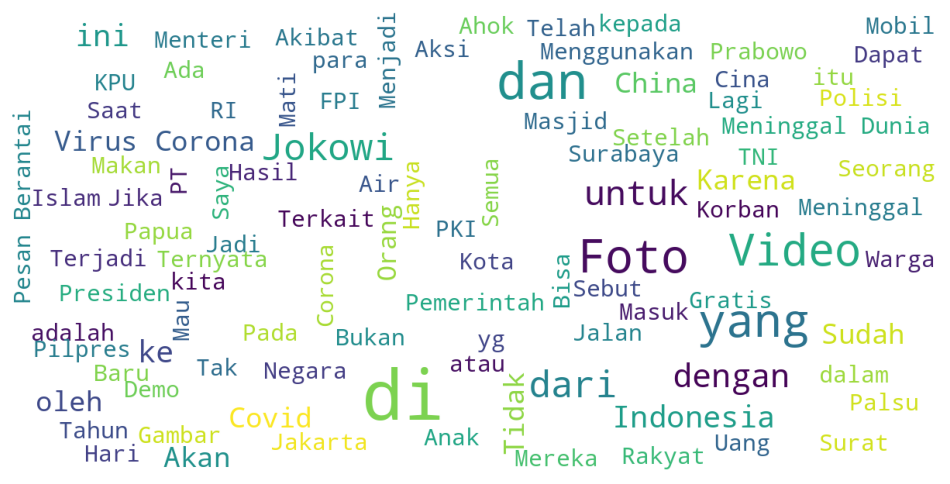

In [24]:
negative_words = ' '.join(text for text in news['judul'][news['label'] == 1])
show_wordcloud(negative_words)

menampilkan wordcloud kata yang sering muncul pada berita yang benar. Hasil wordcloud tersebut tidak jauh berbeda dengan wordcloud pada judul berita yang palsu

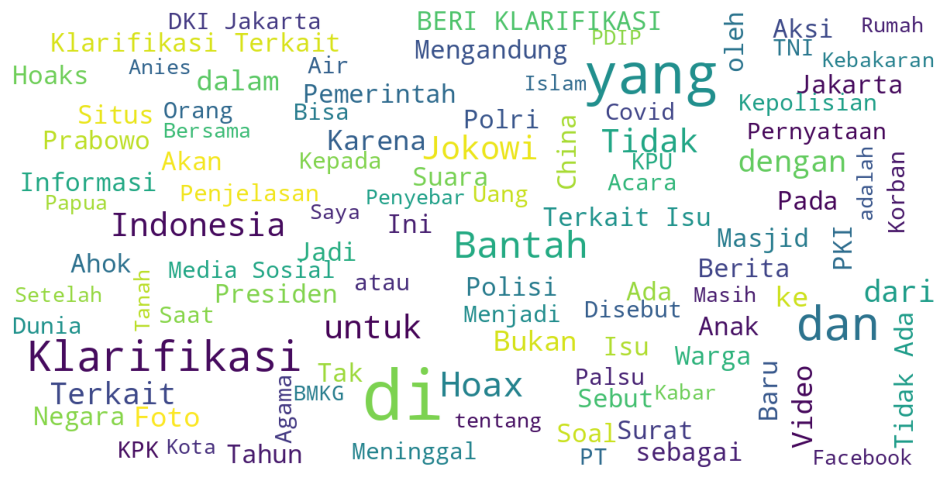

In [25]:
positive_words = ' '.join(text for text in news['judul'][news['label'] == 0])
show_wordcloud(positive_words)

menampilkan visual barplot untuk kata yang sering muncul pada corpus. Disini terlihat bahwa kata yang paling sering muncul yaitu kata "Foto" dan "Video"

<Axes: >

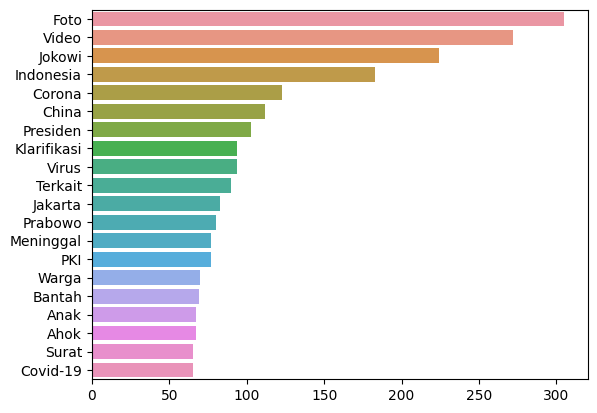

In [26]:
from collections import Counter
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []

for word,count in most[:40]:
    if (word.lower() not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

import library untuk ngrams dan countvectorizer

In [27]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

membuat fungsi untuk menampilkan top ngram yaitu n-kata yang sering muncul pada corpus

In [28]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

menampilkan visual barplot terkait pasangan 2 kata yang sering muncul pada dataset kolom judul. Terlihat bahwa kata "covid 19" dan "virus corona" menjadi kata yang sering muncul

<Axes: >

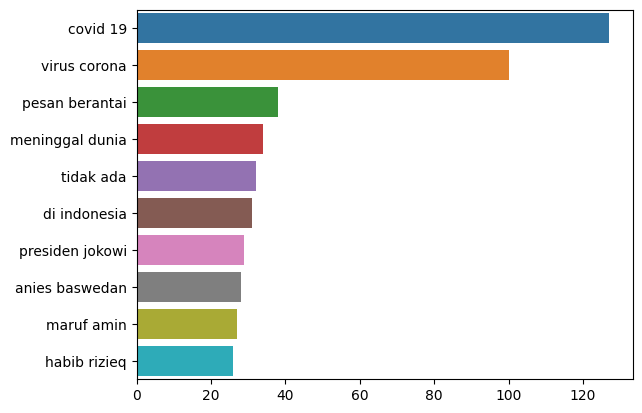

In [29]:
top_n_bigrams=get_top_ngram(news['judul'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

menampilkan grafik bar plot terkait pasangan 4 kata yang sering muncul pada dataset kolom judul. Menariknya pada grafik ini, pasangan 4 kata yang seirng muncul berhubungan dengan pemerintahan dan pandemi covid 19

<Axes: >

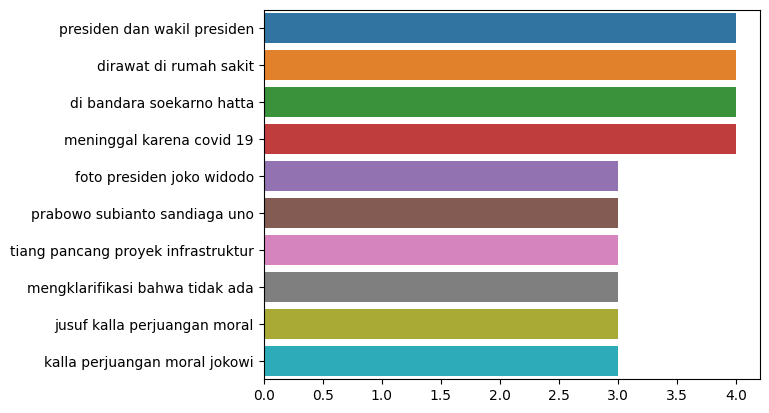

In [30]:
top_tri_grams=get_top_ngram(news['judul'],n=4)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

# Training Machine Learning

Membuat fungsi untuk Text Cleaning dan Pre-processing

In [31]:
def processed_features(features):
  processed_features = []
  for sentence in range(0, len(features)):
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    processed_feature = processed_feature.lower()
    processed_features.append(processed_feature)
  return processed_features

membuat variabel X untuk judul berita dan y untuk label berita

In [32]:
X = news['judul']
y = news['label']

melakukan split dataset dengan pembagian data training dan data test 8:2. Hal ini dilakukan karena dataset tidak terlalu banyak

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

melakukan teks cleaning data training dengan memanggil fungsi processed_features()

In [36]:
features_train = X_train.values
processed_features_train = processed_features(features_train)

melakukan tokenisasi data training dengan teknik TFIDF yang terdapat beberapa parameter sebagai berikut
- max features 2500, artinya membatasi fitur untuk perhitungan diambil hanya sebanyak 2500
- min_df 7, artinya mengabaikan term yang muncul kurang dari 7 dokumen
- max_df 0.8 kita mengabaikan term yang muncul di lebih dari 80% dalam teks.
- stopwords indonesia yang akan menghapus kata yang tidak terlalu penting berdasar corpus library stopwords


In [37]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('indonesian'))
vectorizer
processed_features_train = vectorizer.fit_transform(processed_features_train).toarray()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


melakukan Text Cleaning dan Pre-processing pada data validation

In [38]:
features_validation = X_test.values
processed_features_validation = processed_features(features_validation)

mengubah data validation ke dalam bentuk document-term matrix agar dapat menjadi input model

In [39]:
processed_features_validation = vectorizer.transform(processed_features_validation).toarray()

melakukan training dengan menggunakan algoritma SVM

In [40]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(processed_features_train, y_train)

SVC(kernel='linear')

menguji model dengan data validation yang telah dipersiapkan. Didapatkan hasil skor akurasi sebesar 86%

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

predictions = svm_classifier.predict(processed_features_validation)
cm = confusion_matrix(y_test,predictions)
class_names = ['Bukan Hoax', 'Hoax']
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.72      0.30      0.43       139
           1       0.88      0.98      0.92       708

    accuracy                           0.87       847
   macro avg       0.80      0.64      0.68       847
weighted avg       0.85      0.87      0.84       847

0.8665879574970484


memvisualisasikan confusion matrix model SVM dengan grafik

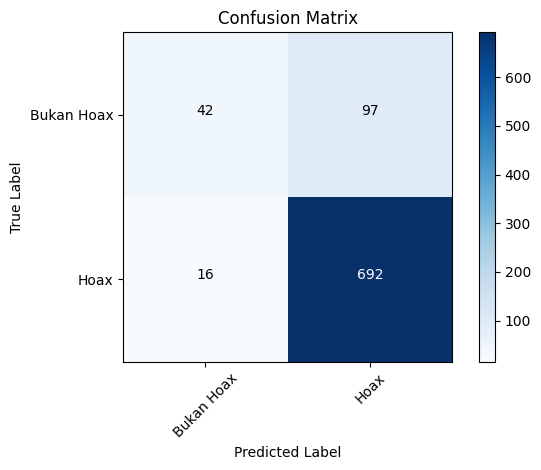

In [48]:
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

plt.figure()
plot_confusion_matrix(cm, class_names)
plt.show()

persentase recall dan f1-score pada identifikasi sentimen 0 (berita benar) cenderung rendah dikarenakan faktor dataaset yang tidak seimbang antara 2 label

# Training Deep Learning

menginstall package yang diperlukan

In [49]:
!pip install transformers[torch]
!pip install accelerate -U
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 30.6 MB/s eta 0:00:00


menginstall package datasets untuk tipe data saat training menggunakan BERT

In [50]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00


membuat tokenizer dari pretraining model indobenchmark/indobert-base-p1

In [51]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p1', do_lower_case=True)

melakukan split data training dan test 8:2

In [52]:
training, validation  = train_test_split(news, test_size=0.2, random_state=24)

mempersiapkan dataset sesuai format agar dapat menjadi input model deep learning

In [53]:
from datasets import Dataset
training = Dataset.from_pandas(training)
validation = Dataset.from_pandas(validation)

melakukan tokenisasi pada data judul untuk data training dan data eval

In [54]:
def tokenize_data(data):
    return tokenizer(data['judul'], padding='max_length', truncation=True, max_length=150)

train_dataset = training.map(tokenize_data, batched=True)
eval_dataset = validation.map(tokenize_data, batched=True)

Map:   0%|          | 0/3384 [00:00<?, ? examples/s]

Map:   0%|          | 0/847 [00:00<?, ? examples/s]

melakukan konfigurasi model dimana akan melakukan training epochs sebanyak 5 kali

In [55]:
from transformers import TrainingArguments

training_args = TrainingArguments("test_trainer", num_train_epochs=5)

Memanggil pretraining model indobenchmark/indobert-base-p1 dengan fine tuning output label menjadi 2 yaitu 0 (fake news) dan 1 (berita benar)

In [56]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


mempersiapkan trainer model

In [57]:
from transformers import Trainer

trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset
)

training data

In [58]:
trainer.train()

Step,Training Loss
500,0.445300
1000,0.379700
1500,0.342400
2000,0.299300


TrainOutput(global_step=2115, training_loss=0.36182125984354224, metrics={'train_runtime': 572.0384, 'train_samples_per_second': 29.578, 'train_steps_per_second': 3.697, 'total_flos': 1304249723640000.0, 'train_loss': 0.36182125984354224, 'epoch': 5.0})

dari hasil training terlihat proses epochs training sesuai konfigurasi yaitu 5 kali. Dan pada proses training terlihat training loss menurun setiap trainingnya.  

## Evaluate Model Deep Learning

menampilkan hasil evaluasi model

In [59]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

evaluation_results = trainer.evaluate()

<ipython-input-59-470b935de535>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [60]:
evaluation_results

{'eval_loss': 0.5489314794540405,
 'eval_runtime': 7.2555,
 'eval_samples_per_second': 116.74,
 'eval_steps_per_second': 14.61,
 'epoch': 5.0}

menguji model terhadap dataset eval

In [61]:
import torch
predictions = []
for text in validation['judul']:
  inputs = tokenizer(text, padding='max_length', truncation=True, max_length=150, return_tensors="pt").to(model.device)
  outputs = model(**inputs)
  predicted_label = torch.argmax(outputs.logits, dim=1).item()
  predictions.append(predicted_label)

menampilkan confusion matrix BErT dengan visualisasi grafik

              precision    recall  f1-score   support

           0       0.67      0.49      0.57       162
           1       0.89      0.94      0.91       685

    accuracy                           0.86       847
   macro avg       0.78      0.72      0.74       847
weighted avg       0.85      0.86      0.85       847

0.8571428571428571


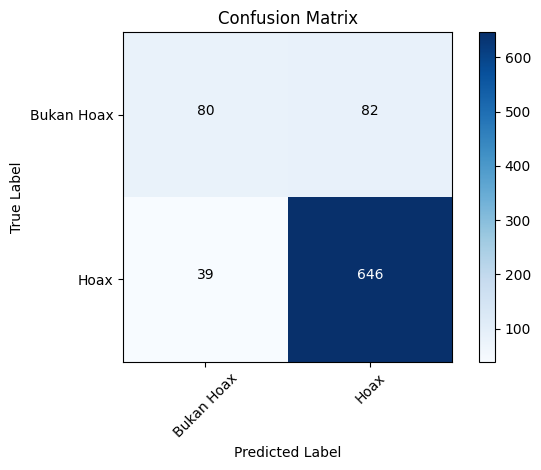

In [63]:
cm = confusion_matrix(validation['label'],predictions)
print(classification_report(validation['label'],predictions))
print(accuracy_score(validation['label'], predictions))

plt.figure()
plot_confusion_matrix(cm, class_names)
plt.show()

Dari hasil confusion matrix dataset eval, terlihat bahwa hasil prediksi pada deep learning menggunakan pretraining model indobenchmark/indobert-base-p1 tidak jauh berbeda dengan SVM. Hal ini disebabkan beberapa faktor seperti deep learning yang cenderung membutuhkan data yang besar namun dataset yang dimiliki cenderung sedikit. Faktor lainnya seperti kompleksitas model, dan tugas yang sederhana yang hanya melakukan sentimen analisis